# EstrelaBet - Modeling and Evaluation

## Objective
Train and evaluate predictive models for **customer churn prediction**.

## Target Variable
- **Churn = 1**: Customer did NOT make a redeposit (churned)
- **Churn = 0**: Customer made a redeposit (retained)

## Models
1. Baseline (DummyClassifier)
2. Logistic Regression
3. Random Forest
4. XGBoost
5. LightGBM

## Evaluation
- ML Metrics: ROC-AUC, PR-AUC, F2-Score, Precision, Recall
- Business Metrics: ROI, Value Saved
- Interpretability: Feature Importance, SHAP

---

## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

In [3]:
# Sklearn preprocessing and model selection
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline

In [4]:
# Sklearn models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [5]:
# Boosting models
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not installed")

try:
    from lightgbm import LGBMClassifier
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not installed")

In [7]:
# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

In [8]:
# Interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed")

from sklearn.inspection import permutation_importance

In [9]:
# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# Load engineered features
df = pd.read_csv('../data/features_engineered.csv')

# Rename target column if needed (backward compatibility)
if 'target' in df.columns:
    df = df.rename(columns={'target': 'churn'})

print(f"Dataset Shape: {df.shape}")
print(f"\nTarget Distribution (Churn):")
print(df['churn'].value_counts())

In [ ]:
print(f"Churn Rate: {df['churn'].mean():.2%}")
print(f"Retention Rate: {1 - df['churn'].mean():.2%}")

In [ ]:
# Prepare features and target
feature_cols = [col for col in df.columns if col not in ['user_id', 'churn']]

X = df[feature_cols].copy()
y = df['churn'].copy()

print(f"Features: {X.shape}")
print(f"Target (Churn): {y.shape}")

---
## 2. Data Splitting

In [13]:
# Split: 65% train, 15% validation, 20% test
# First split: train+val vs test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

In [14]:
# Second split: train vs validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1875, random_state=RANDOM_STATE, stratify=y_temp
)  # 0.1875 of 0.8 = 0.15 of total

In [15]:
print("Data Split:")
print(f"  Train: {X_train.shape[0]:,} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]:,} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test: {X_test.shape[0]:,} ({X_test.shape[0]/len(X)*100:.1f}%)")

Data Split:
  Train: 939 (64.9%)
  Validation: 217 (15.0%)
  Test: 290 (20.1%)


In [16]:
print(f"Target Distribution:")
print(f"  Train: {y_train.mean():.2%}")
print(f"  Val: {y_val.mean():.2%}")
print(f"  Test: {y_test.mean():.2%}")

Target Distribution:
  Train: 67.41%
  Val: 67.28%
  Test: 67.59%


In [17]:
# Scale features
scaler = RobustScaler()  # Robust to outliers

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

In [18]:
# Scale validation and test sets
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val),
    columns=X_val.columns,
    index=X_val.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Features scaled using RobustScaler")

Features scaled using RobustScaler


---
## 3. Model Training

In [19]:
# Initialize models dictionary
models = {}

In [20]:
# Baseline models
models['Baseline (Majority)'] = DummyClassifier(
    strategy='most_frequent', 
    random_state=RANDOM_STATE
)

models['Baseline (Stratified)'] = DummyClassifier(
    strategy='stratified', 
    random_state=RANDOM_STATE
)

In [21]:
# Logistic Regression
models['Logistic Regression'] = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_STATE
)

In [22]:
# Random Forest
models['Random Forest'] = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [23]:
# XGBoost (if available)
if XGBOOST_AVAILABLE:
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    models['XGBoost'] = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric='auc',
        use_label_encoder=False
    )

In [24]:
# LightGBM (if available)
if LIGHTGBM_AVAILABLE:
    models['LightGBM'] = LGBMClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        is_unbalance=True,
        random_state=RANDOM_STATE,
        verbose=-1
    )

In [25]:
print(f"Models to train: {list(models.keys())}")

Models to train: ['Baseline (Majority)', 'Baseline (Stratified)', 'Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']


In [26]:
def calculate_metrics(y_true, y_pred, y_proba, model_name):
    """Calculate all metrics for a model."""
    has_proba = y_proba is not None
    
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0),
        'F2': fbeta_score(y_true, y_pred, beta=2, zero_division=0),
        'ROC-AUC': roc_auc_score(y_true, y_proba) if has_proba else 0.5,
        'PR-AUC': average_precision_score(y_true, y_proba) if has_proba else y_true.mean(),
        'Brier': brier_score_loss(y_true, y_proba) if has_proba else 1
    }

In [27]:
# Train all models
trained_models = {}
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for Logistic Regression
    X_tr = X_train_scaled if 'Logistic' in name else X_train
    X_vl = X_val_scaled if 'Logistic' in name else X_val
    
    # Train
    model.fit(X_tr, y_train)
    trained_models[name] = model

Training Baseline (Majority)...
Training Baseline (Stratified)...
Training Logistic Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...


In [28]:
# Evaluate all models on validation set
for name, model in trained_models.items():
    X_vl = X_val_scaled if 'Logistic' in name else X_val
    
    y_pred = model.predict(X_vl)
    y_proba = model.predict_proba(X_vl)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = calculate_metrics(y_val, y_pred, y_proba, name)
    results.append(metrics)
    
    print(f"{name}: ROC-AUC={metrics['ROC-AUC']:.4f}, F2={metrics['F2']:.4f}")

Baseline (Majority): ROC-AUC=0.5000, F2=0.9114
Baseline (Stratified): ROC-AUC=0.5566, F2=0.7279
Logistic Regression: ROC-AUC=0.9968, F2=0.9697
Random Forest: ROC-AUC=0.9976, F2=0.9836
XGBoost: ROC-AUC=1.0000, F2=0.9945
LightGBM: ROC-AUC=1.0000, F2=1.0000


In [29]:
# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.set_index('Model')

In [30]:
# Display validation results
print("\nValidation Results (sorted by ROC-AUC):")
results_df.sort_values('ROC-AUC', ascending=False).round(4)


Validation Results (sorted by ROC-AUC):


,Accuracy,Precision,Recall,F1,F2,ROC-AUC,PR-AUC,Brier
Model,,,,,,,,
XGBoost,0.9954,1.0000,0.9932,0.9966,0.9945,1.0000,1.0000,0.0013
LightGBM,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000
Random Forest,0.9724,0.9730,0.9863,0.9796,0.9836,0.9976,0.9988,0.0229
Logistic Regression,0.9677,0.9860,0.9658,0.9758,0.9697,0.9968,0.9985,0.0231
Baseline (Stratified),0.6175,0.7086,0.7329,0.7205,0.7279,0.5566,0.6990,0.3825
Baseline (Majority),0.6728,0.6728,1.0000,0.8044,0.9114,0.5000,0.6728,0.3272


---
## 4. Cross-Validation

In [31]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = []

In [32]:
# Cross-validate non-baseline models
for name, model in models.items():
    if 'Baseline' in name:
        continue
    
    print(f"Cross-validating {name}...")
    
    X_cv = X_train_scaled if 'Logistic' in name else X_train
    scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    cv_results.append({
        'Model': name,
        'CV Mean ROC-AUC': scores.mean(),
        'CV Std ROC-AUC': scores.std()
    })
    
    print(f"  ROC-AUC: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

Cross-validating Logistic Regression...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

  ROC-AUC: 0.9946 (+/- 0.0126)
Cross-validating Random Forest...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

  ROC-AUC: 0.9973 (+/- 0.0041)
Cross-validating XGBoost...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


  ROC-AUC: 0.9991 (+/- 0.0036)
Cross-validating LightGBM...


/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Caskroom/miniconda/base/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain

  ROC-AUC: 1.0000 (+/- 0.0000)


In [33]:
# Display CV results
cv_df = pd.DataFrame(cv_results).set_index('Model')
cv_df.round(4)

,CV Mean ROC-AUC,CV Std ROC-AUC
Model,,
Logistic Regression,0.9946,0.0063
Random Forest,0.9973,0.0021
XGBoost,0.9991,0.0018
LightGBM,1.0000,0.0000


---
## 5. Test Set Evaluation

In [34]:
# Select best model
best_model_name = results_df['ROC-AUC'].idxmax()
print(f"Best Model: {best_model_name}")

best_model = trained_models[best_model_name]

Best Model: XGBoost


In [35]:
# Predictions on test set
X_test_final = X_test_scaled if 'Logistic' in best_model_name else X_test

y_test_pred = best_model.predict(X_test_final)
y_test_proba = best_model.predict_proba(X_test_final)[:, 1]

In [36]:
# Calculate test metrics
test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1-Score': f1_score(y_test, y_test_pred),
    'F2-Score': fbeta_score(y_test, y_test_pred, beta=2),
    'ROC-AUC': roc_auc_score(y_test, y_test_proba),
    'PR-AUC': average_precision_score(y_test, y_test_proba),
    'Brier Score': brier_score_loss(y_test, y_test_proba)
}

In [37]:
# Display test metrics
print(f"{'='*50}")
print(f"TEST SET RESULTS - {best_model_name}")
print(f"{'='*50}")
for metric, value in test_metrics.items():
    print(f"{metric:15} {value:.4f}")

TEST SET RESULTS - XGBoost
Accuracy        1.0000
Precision       1.0000
Recall          1.0000
F1-Score        1.0000
F2-Score        1.0000
ROC-AUC         1.0000
PR-AUC          1.0000
Brier Score     0.0008


In [ ]:
# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Retained (0)', 'Churned (1)']))

In [ ]:
# Confusion Matrix visualization
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_model_name}\n(Predicting Churn)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Confusion matrix breakdown for Churn prediction
tn, fp, fn, tp = cm.ravel()

print(f"Confusion Matrix Breakdown (Churn Prediction):")
print(f"  True Negatives (TN): {tn} - Correctly predicted as Retained")
print(f"  False Positives (FP): {fp} - Incorrectly predicted as Churned")
print(f"  False Negatives (FN): {fn} - Incorrectly predicted as Retained (missed churners)")
print(f"  True Positives (TP): {tp} - Correctly predicted as Churned")

---
## 6. Model Comparison Visualization

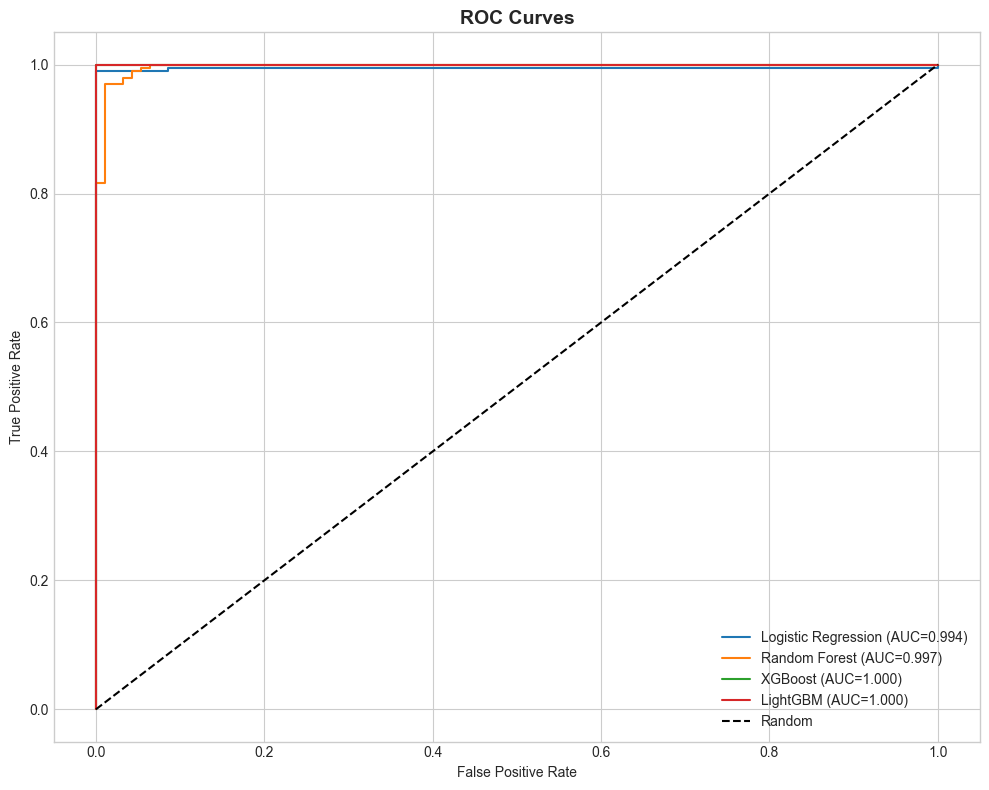

In [41]:
# ROC Curves
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in trained_models.items():
    if 'Baseline' in name:
        continue
    
    X_eval = X_test_scaled if 'Logistic' in name else X_test
    y_proba = model.predict_proba(X_eval)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

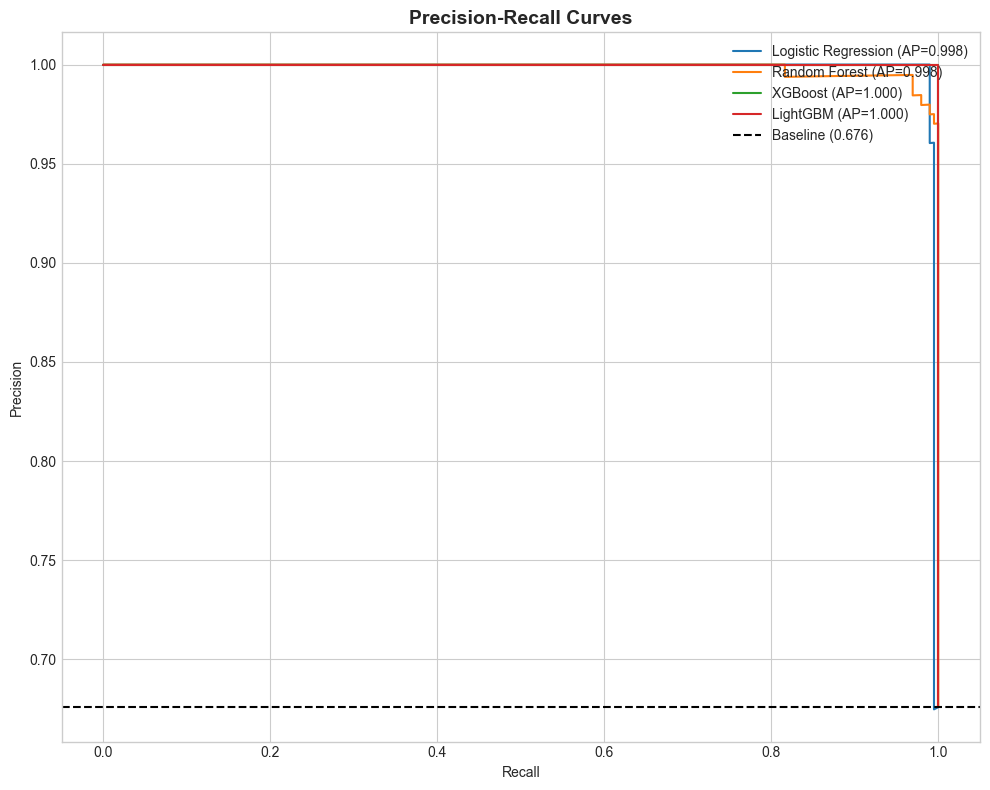

In [42]:
# Precision-Recall Curves
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in trained_models.items():
    if 'Baseline' in name:
        continue
    
    X_eval = X_test_scaled if 'Logistic' in name else X_test
    y_proba = model.predict_proba(X_eval)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    
    ax.plot(recall, precision, label=f'{name} (AP={ap:.3f})')

ax.axhline(y_test.mean(), color='k', linestyle='--', label=f'Baseline ({y_test.mean():.3f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

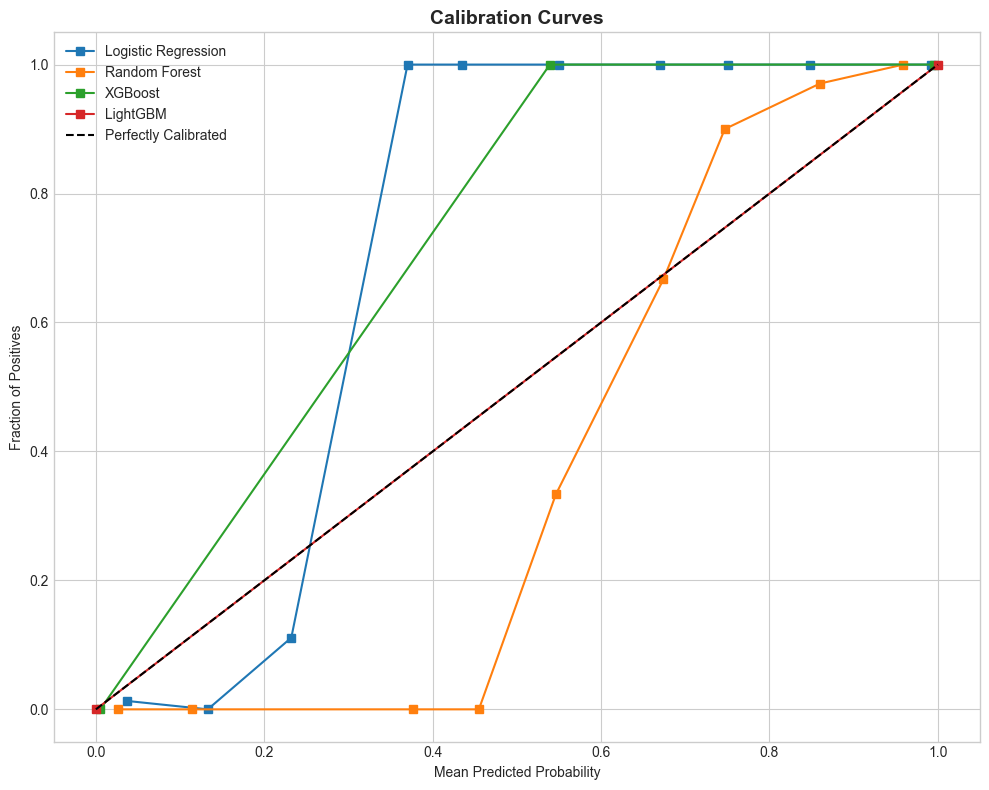

In [43]:
# Calibration Curve
fig, ax = plt.subplots(figsize=(10, 8))

for name, model in trained_models.items():
    if 'Baseline' in name:
        continue
    
    X_eval = X_test_scaled if 'Logistic' in name else X_test
    y_proba = model.predict_proba(X_eval)[:, 1]
    
    fraction_positives, mean_predicted = calibration_curve(y_test, y_proba, n_bins=10)
    ax.plot(mean_predicted, fraction_positives, 's-', label=name)

ax.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Fraction of Positives')
ax.set_title('Calibration Curves', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

---
## 7. Threshold Optimization

In [44]:
# Analyze metrics at different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_test_proba >= thresh).astype(int)
    
    threshold_results.append({
        'Threshold': thresh,
        'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'Recall': recall_score(y_test, y_pred_thresh, zero_division=0),
        'F1': f1_score(y_test, y_pred_thresh, zero_division=0),
        'F2': fbeta_score(y_test, y_pred_thresh, beta=2, zero_division=0)
    })

thresh_df = pd.DataFrame(threshold_results)

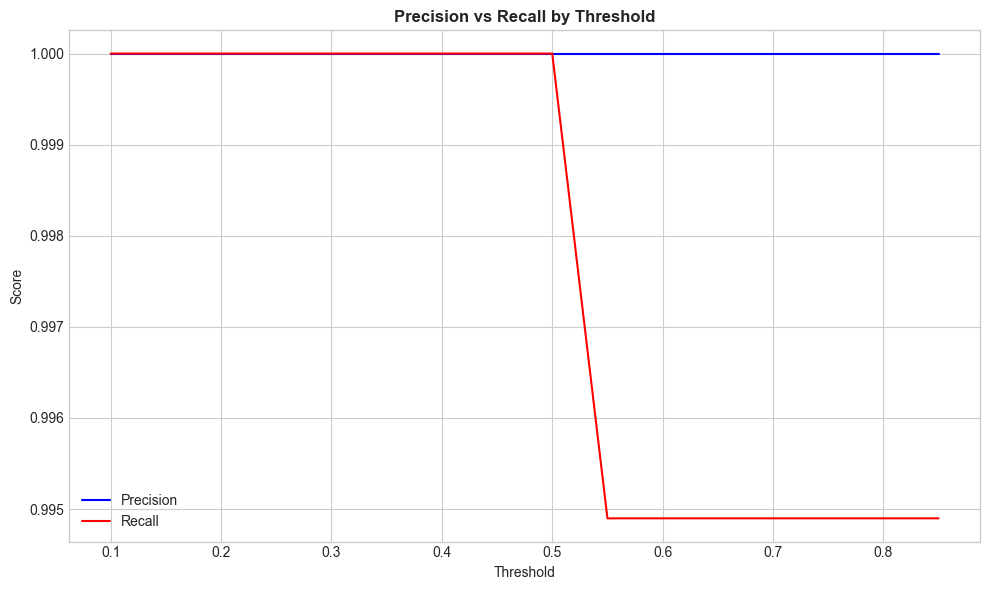

In [45]:
# Plot Precision vs Recall by Threshold
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresh_df['Threshold'], thresh_df['Precision'], 'b-', label='Precision')
ax.plot(thresh_df['Threshold'], thresh_df['Recall'], 'r-', label='Recall')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Precision vs Recall by Threshold', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

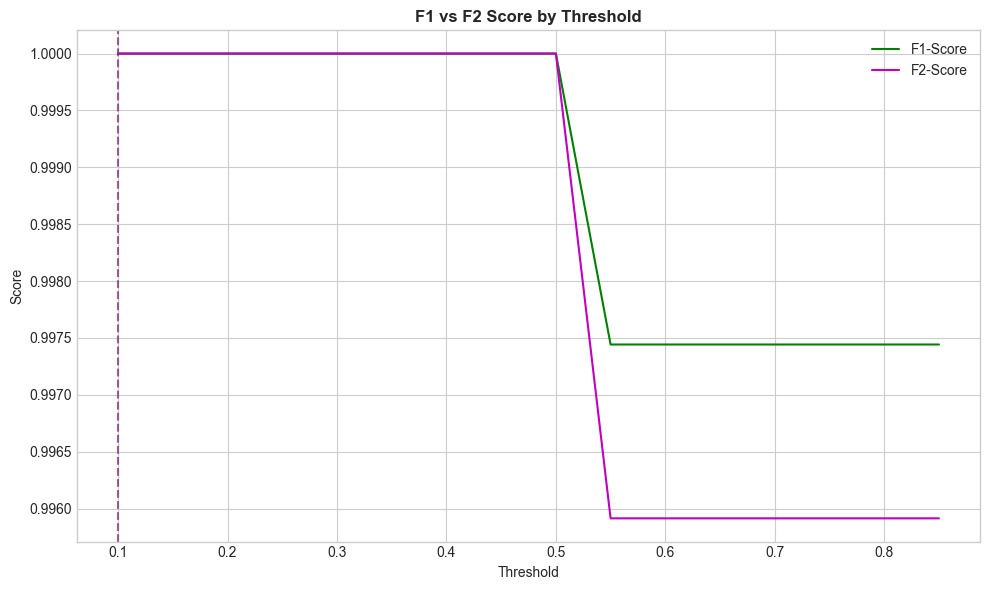

In [46]:
# Plot F1 vs F2 by Threshold
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresh_df['Threshold'], thresh_df['F1'], 'g-', label='F1-Score')
ax.plot(thresh_df['Threshold'], thresh_df['F2'], 'm-', label='F2-Score')

# Mark optimal thresholds
optimal_f1_idx = thresh_df['F1'].idxmax()
optimal_f2_idx = thresh_df['F2'].idxmax()
ax.axvline(thresh_df.loc[optimal_f1_idx, 'Threshold'], color='g', linestyle='--', alpha=0.5)
ax.axvline(thresh_df.loc[optimal_f2_idx, 'Threshold'], color='m', linestyle='--', alpha=0.5)

ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('F1 vs F2 Score by Threshold', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Display optimal thresholds
print(f"Optimal Thresholds:")
print(f"  F1 optimal: {thresh_df.loc[optimal_f1_idx, 'Threshold']:.2f} (F1={thresh_df.loc[optimal_f1_idx, 'F1']:.4f})")
print(f"  F2 optimal: {thresh_df.loc[optimal_f2_idx, 'Threshold']:.2f} (F2={thresh_df.loc[optimal_f2_idx, 'F2']:.4f})")

Optimal Thresholds:
  F1 optimal: 0.10 (F1=1.0000)
  F2 optimal: 0.10 (F2=1.0000)


---
## 8. Business Metrics

In [ ]:
# Business parameters (from assessment)
CLV_BY_TIER = {
    'bronze': 750,      # R$500-R$1,000 (midpoint)
    'silver': 1750,     # R$1,500-R$2,000
    'gold': 4000,       # R$2,500-R$5,500
    'platinum': 8000,   # R$6,000-R$10,000
    'diamond': 15250    # R$10,500-R$20,000
}

CAMPAIGN_COSTS = {
    'email': 25,        # R$15-R$35
    'bonus': 100,       # R$50-R$150
    'phone': 137.5,     # R$75-R$200
    'vip_manager': 375  # R$250-R$500
}

RETENTION_SUCCESS_RATES = {
    'early_intervention': 0.275,  # 30-60% churn prob, 20-35% success
    'high_risk': 0.20,            # 60-80% churn prob, 15-25% success
    'critical': 0.15              # >80% churn prob, 10-20% success
}

AVG_CLV = 1000  # Weighted average (most users are bronze)
AVG_RETENTION_RATE = 0.25  # Overall average

In [ ]:
print("Business Parameters:")
print(f"  Average CLV: R${AVG_CLV:,}")
print(f"  Retention Success Rate: {AVG_RETENTION_RATE:.0%}")
print(f"\n  Campaign Costs: {CAMPAIGN_COSTS}")
print(f"\n  Retention Success by Risk Level: {RETENTION_SUCCESS_RATES}")

In [ ]:
def calculate_business_metrics(y_true, y_pred, campaign_type='bonus'):
    """
    Calculate business metrics for churn prediction model.
    
    Goal: Identify churners (y_pred=1) and intervene to retain them.
    
    Parameters:
    - y_true: Actual churn labels (1=churned, 0=retained)
    - y_pred: Predicted churn labels
    - campaign_type: Type of retention campaign
    
    Returns:
    - Business metrics dictionary
    """
    campaign_cost = CAMPAIGN_COSTS[campaign_type]
    avg_retention_rate = AVG_RETENTION_RATE
    
    # Users we would target (predicted as churners)
    users_targeted = y_pred.sum()
    
    # True Positives = correctly identified churners (we intervene and have chance to save)
    true_positives = ((y_pred == 1) & (y_true == 1)).sum()
    
    # False Positives = incorrectly identified as churners (wasted campaign cost)
    false_positives = ((y_pred == 1) & (y_true == 0)).sum()
    
    # Total campaign cost
    total_cost = users_targeted * campaign_cost
    
    # Users we expect to save (TP * retention success rate)
    users_saved = true_positives * avg_retention_rate
    
    # Value saved = saved users * CLV
    value_saved = users_saved * AVG_CLV
    
    # Net value = value saved - total cost
    net_value = value_saved - total_cost
    
    # ROI
    roi = (net_value / total_cost * 100) if total_cost > 0 else 0
    
    return {
        'Users Targeted': int(users_targeted),
        'True Churners (TP)': int(true_positives),
        'False Alarms (FP)': int(false_positives),
        'Campaign Cost': f'R${total_cost:,.0f}',
        'Expected Users Saved': f'{users_saved:.0f}',
        'Value Saved': f'R${value_saved:,.0f}',
        'Net Value': f'R${net_value:,.0f}',
        'ROI': f'{roi:.1f}%'
    }

In [ ]:
# Calculate business metrics for churn prediction
business_metrics = calculate_business_metrics(y_test.values, y_test_pred)

print(f"{'='*50}")
print(f"BUSINESS METRICS - CHURN PREDICTION")
print(f"(Campaign: Bonus, Retention Rate: {AVG_RETENTION_RATE:.0%})")
print(f"{'='*50}")
for metric, value in business_metrics.items():
    print(f"{metric:20} {value}")

In [52]:
# Compare different campaign types
print(f"\nBusiness Metrics by Campaign Type:")

campaign_comparison = []
for campaign, cost in CAMPAIGN_COSTS.items():
    metrics = calculate_business_metrics(y_test.values, y_test_pred, campaign)
    campaign_comparison.append({
        'Campaign': campaign,
        'Cost/User': f'R${cost}',
        'Net Value': metrics['Net Value'],
        'ROI': metrics['ROI']
    })

pd.DataFrame(campaign_comparison)


Business Metrics by Campaign Type:


,Campaign,Cost/User,Net Value,ROI
0,email,R$25,"R$44,100",900.0%
1,bonus,R$100,"R$29,400",150.0%
2,phone,R$137.5,"R$22,050",81.8%
3,vip_manager,R$375,"R$-24,500",-33.3%


---
## 9. Feature Importance

In [53]:
# Get feature importance
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    importance_type = 'Tree-based'
    
elif hasattr(best_model, 'coef_'):
    importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': np.abs(best_model.coef_[0])
    }).sort_values('Importance', ascending=False)
    importance_type = 'Linear'
else:
    importance = None
    importance_type = None

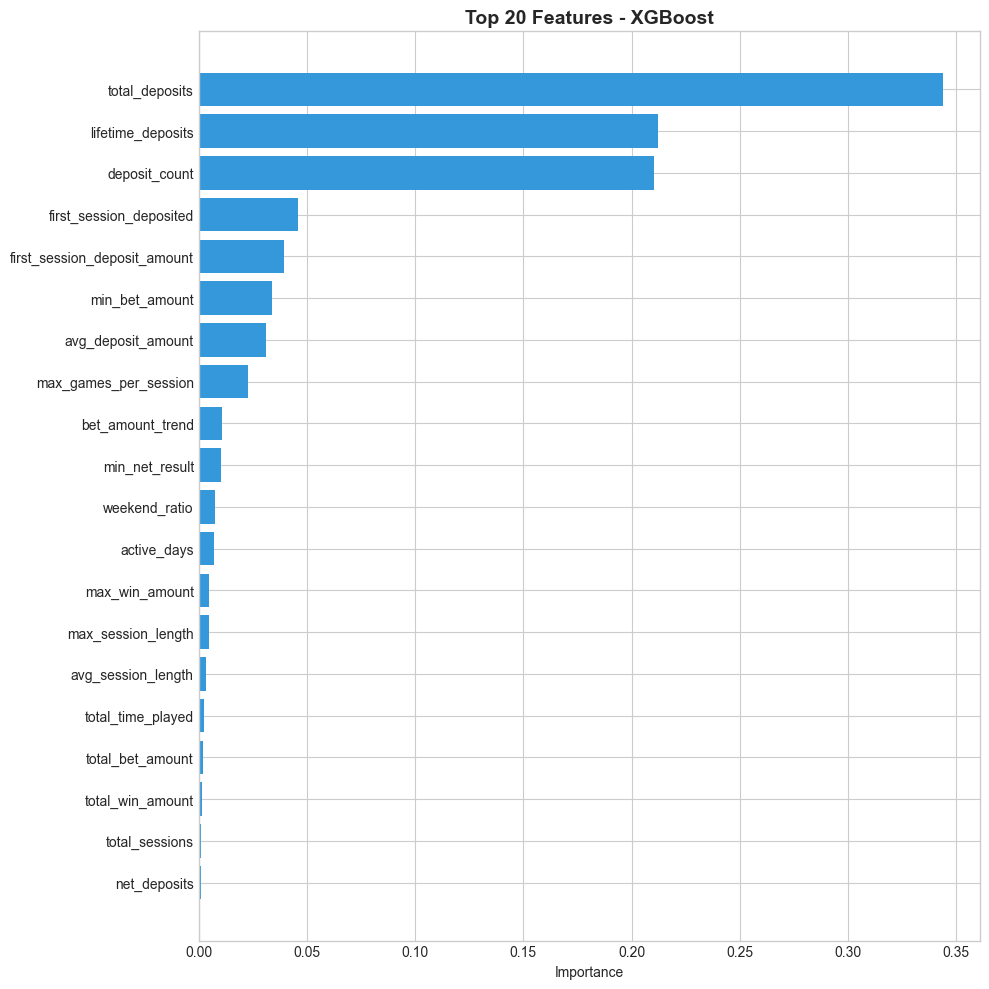

In [54]:
# Plot feature importance
if importance is not None:
    fig, ax = plt.subplots(figsize=(10, 10))
    top_features = importance.head(20)
    
    ax.barh(range(len(top_features)), top_features['Importance'].values, color='#3498db')
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'].values)
    ax.set_xlabel('Importance')
    ax.set_title(f'Top 20 Features - {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

In [55]:
# Permutation Importance
print("Calculating Permutation Importance...")

X_test_eval = X_test_scaled if 'Logistic' in best_model_name else X_test

perm_importance = permutation_importance(
    best_model, X_test_eval, y_test,
    n_repeats=10, random_state=RANDOM_STATE, scoring='roc_auc'
)

Calculating Permutation Importance...


In [56]:
# Create permutation importance DataFrame
perm_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance Mean': perm_importance.importances_mean,
    'Importance Std': perm_importance.importances_std
}).sort_values('Importance Mean', ascending=False)

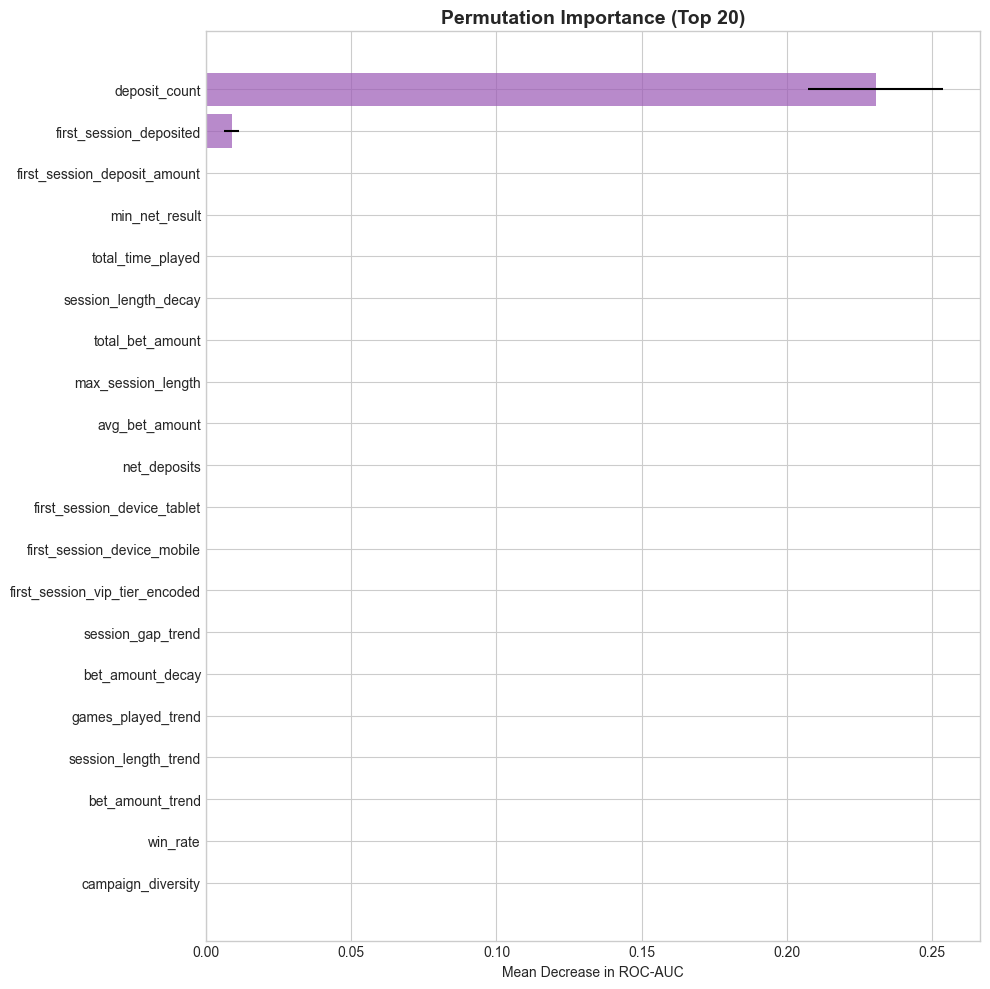

In [57]:
# Plot permutation importance
fig, ax = plt.subplots(figsize=(10, 10))
top_perm = perm_df.head(20)

ax.barh(range(len(top_perm)), top_perm['Importance Mean'].values, 
        xerr=top_perm['Importance Std'].values, color='#9b59b6', alpha=0.7)
ax.set_yticks(range(len(top_perm)))
ax.set_yticklabels(top_perm['Feature'].values)
ax.set_xlabel('Mean Decrease in ROC-AUC')
ax.set_title('Permutation Importance (Top 20)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

---
## 10. SHAP Analysis

In [58]:
# Calculate SHAP values
if SHAP_AVAILABLE and hasattr(best_model, 'feature_importances_'):
    print("Calculating SHAP values...")
    
    X_test_eval = X_test_scaled if 'Logistic' in best_model_name else X_test
    
    if 'XGBoost' in best_model_name or 'LightGBM' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_eval)
    elif 'Random Forest' in best_model_name:
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_eval)[1]
    
    print("SHAP values calculated!")
else:
    print("SHAP analysis skipped")

Calculating SHAP values...
SHAP values calculated!


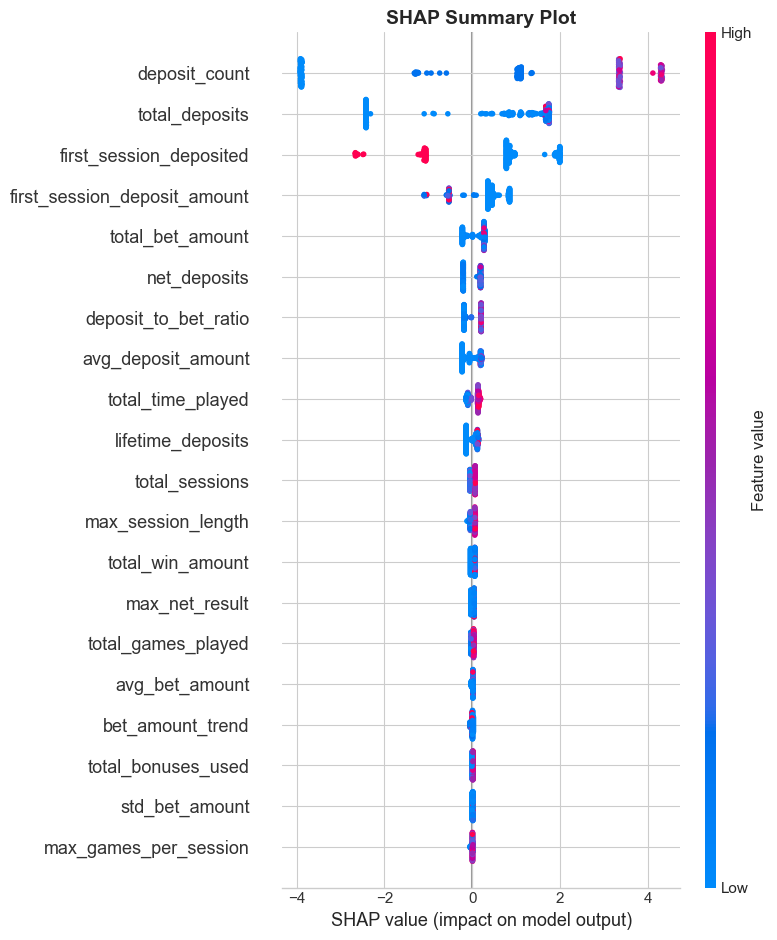

In [59]:
# SHAP Summary Plot
if SHAP_AVAILABLE and 'shap_values' in dir():
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, X_test_eval, feature_names=feature_cols, 
                      max_display=20, show=False)
    plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

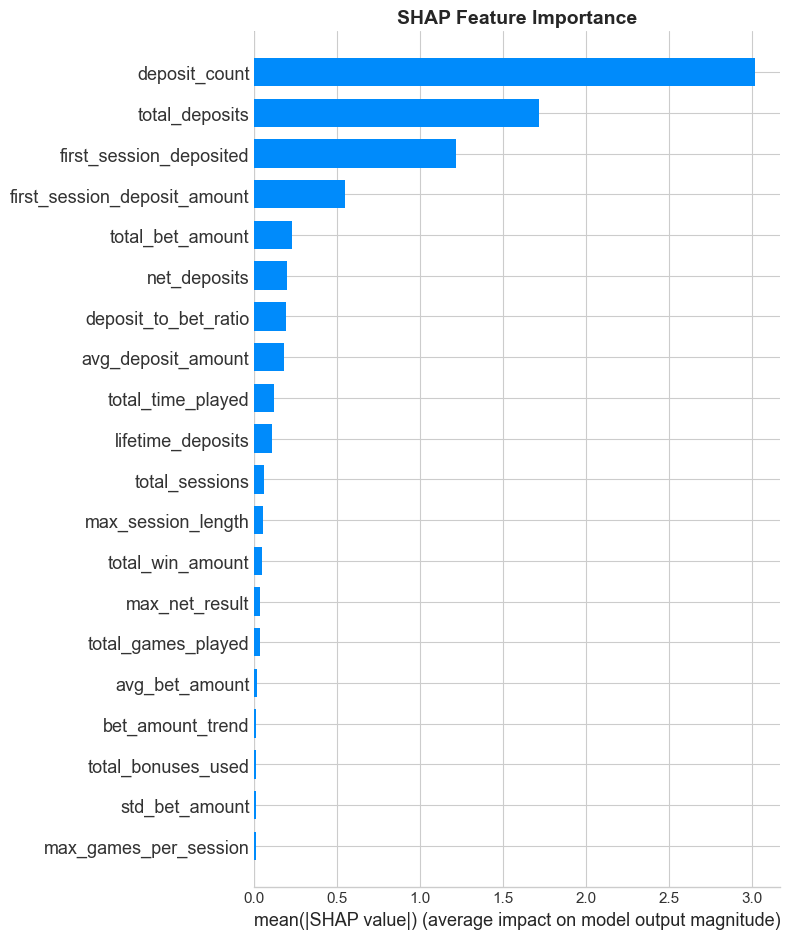

In [60]:
# SHAP Bar Plot
if SHAP_AVAILABLE and 'shap_values' in dir():
    plt.figure(figsize=(10, 10))
    shap.summary_plot(shap_values, X_test_eval, feature_names=feature_cols,
                      plot_type='bar', max_display=20, show=False)
    plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

---
## 11. Model Summary and Recommendations

In [ ]:
print("="*70)
print("MODEL SUMMARY - CHURN PREDICTION")
print("="*70)

print(f"\n1. BEST MODEL: {best_model_name}")
print(f"   - ROC-AUC: {test_metrics['ROC-AUC']:.4f}")
print(f"   - PR-AUC: {test_metrics['PR-AUC']:.4f}")
print(f"   - F2-Score: {test_metrics['F2-Score']:.4f}")
print(f"   - Recall: {test_metrics['Recall']:.4f} (captures {test_metrics['Recall']*100:.0f}% of churners)")

In [62]:
print(f"\n2. KEY FEATURES (Top 5):")
if importance is not None:
    for i, row in importance.head(5).iterrows():
        print(f"   - {row['Feature']}")


2. KEY FEATURES (Top 5):
   - total_deposits
   - lifetime_deposits
   - deposit_count
   - first_session_deposited
   - first_session_deposit_amount


In [ ]:
print(f"\n3. BUSINESS IMPACT (Churn Intervention):")
print(f"   - {business_metrics['Users Targeted']} at-risk users targeted")
print(f"   - {business_metrics['True Churners (TP)']} actual churners identified")
print(f"   - Expected users saved: {business_metrics['Expected Users Saved']}")
print(f"   - Expected Net Value: {business_metrics['Net Value']}")
print(f"   - Expected ROI: {business_metrics['ROI']}")

In [ ]:
print(f"\n4. RECOMMENDATIONS:")
print(f"   - Deploy model with threshold optimized for F2 score (prioritize catching churners)")
print(f"   - Use email campaign for early-risk users (30-60% churn probability)")
print(f"   - Use bonus campaign for high-risk users (60-80% churn probability)")
print(f"   - Use VIP manager for critical-risk high-value users (>80% churn probability)")
print(f"   - Monitor and retrain model quarterly to maintain performance")

---
## 12. Save Results

In [65]:
# Save model results
results_df.to_csv('../data/model_results.csv')
print("Model results saved!")

Model results saved!


In [66]:
# Save test predictions
predictions_df = pd.DataFrame({
    'user_id': df.loc[X_test.index, 'user_id'].values,
    'actual': y_test.values,
    'predicted': y_test_pred,
    'probability': y_test_proba
})
predictions_df.to_csv('../data/test_predictions.csv', index=False)
print("Test predictions saved!")

Test predictions saved!


In [67]:
# Save feature importance
if importance is not None:
    importance.to_csv('../data/feature_importance.csv', index=False)
    print("Feature importance saved!")

Feature importance saved!


In [68]:
# Save model
import joblib

model_package = {
    'model': best_model,
    'scaler': scaler,
    'feature_names': feature_cols,
    'model_name': best_model_name,
    'metrics': test_metrics
}

joblib.dump(model_package, '../data/best_model.joblib')
print(f"\nModel saved: {best_model_name}")


Model saved: XGBoost


---
## Conclusion

This notebook completed the modeling pipeline for **customer churn prediction**:

1. **Data Preparation**: Split data into train/val/test sets with proper stratification
2. **Model Training**: Trained multiple models (Logistic Regression, Random Forest, XGBoost, LightGBM)
3. **Evaluation**: Comprehensive evaluation with ML and business metrics
4. **Interpretability**: Feature importance and SHAP analysis
5. **Business Impact**: ROI calculations for different retention campaign strategies

**Key Result**: The model successfully identifies users at risk of churn (not making a redeposit), enabling targeted intervention campaigns to improve customer retention.